# Prepare knowledge base from PDF
This interactive notebook provides step-by-step guidance on creating knowledge bases from PDF documents. The process involves generating 'Embeddings' for the provided text data. Presently, our support extends to calculating embeddings using:
- Open AI
- AWS Bedrock
- Ada 002 on AWS
  
Before starting, it's advisable to determine which embeddings you intend to utilize. You'll need to set up corresponding credentials and permissions, which are elaborated in the relevant sections of the notebook.

## Import the required libraries

> Note: Run the 'jupyter notebook' command from within the '/app' directory to avoid issues with importing custom modules

In [1]:
import sys
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
import PyPDF2
import tiktoken
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.append("..")
from shared.embeddings import Embeddings
from shared.services.config_service import ConfigService

## Read the PDF file
Make sure to update the path (**file_path**) so that it points to a PDF file you want to ingest.

In [2]:
file_path = '../resources/static/prompt_samples/example_ingenuity.pdf'

with open(file_path, 'rb') as pdf_file:
    pdf_text = []
    metadatas = []
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    page_number = 1
    for page in pdf_reader.pages:
        pdf_text.append(page.extract_text())
        metadatas.append({ "page": page_number, "file": pdf_file.name })
        page_number += 1 

print(f'Loaded {page_number} pages from {file_path}')

Loaded 25 pages from ../resources/static/prompt_samples/example_ingenuity.pdf


## Load a text splitter
Note: tiktoken is used only to partition text properly.

In [3]:
tiktoken.encoding_for_model('gpt-3.5-turbo')
tokenizer = tiktoken.get_encoding('cl100k_base')

def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=600,
        chunk_overlap=80,
        length_function=tiktoken_len,
        separators=["\n\n", "\n", " ", ""]
    )

## 📌 Choose the embedding provider
Currently supported values are  "OpenAI" , "AWS-Bedrock" and "Ada 002".  Embeddings are loaded automatically based on settings in the **config.yaml** file.
- When we choose "OpenAI", "OpenAI" embedding model is used to generate embeddings. The notebook uses "gpt-3.5-turbo-16k" model for validating the generated knowledgebase using a small RAG workflow towards the end of the notebook.
  
- When we choose "AWS-Bedrock", embeddings are calculated using a AWS Bedrock model. The notebook uses 'anthropic.claude-v2' model to execute the RAG workflow at the end. When using AWS Bedrock credentials should be configured on the machine running this notebook using **AWS CLI (aws configure)**. The user should have **'AmazonBedrockFullAccess'** permissions.


> The code shown below loads the appropriate embeddings object based on 'embeddings' block in config.yml

## Load and Test the loaded embedding provider
The below code will make a test call to the embeddings of choice. In case of error please **do not proceed**. Resolve the error before running the next cell

In [11]:
sample_text = ['''
This is some text
'''*120]

team_ai_embeddings = Embeddings(ConfigService.load_embedding_model("../config.yaml"))
dummy_metadata = []
dummy_metadata.append({"page": 0, "file": 'sample.txt'})
knowledge_base = team_ai_embeddings.generate_from_documents(sample_text,dummy_metadata)
chunks = text_splitter.create_documents(sample_text)
assert(len(chunks) == 2)

In [12]:
query = sample_text[0][0:100]
docs = knowledge_base.similarity_search(query)
if len(docs) == 2:
    print("\033[42mAll OK\033[0m")
    print("Embeddings test result OK , please continue executing rest of the code")
else:
    print("\033[41mError\033[0m")
    print("There was a error. Please check all preceeding cells for errors")

All OK
Embeddings test result OK , please continue executing rest of the code


## Run the knowledge base creation code
Now that we have tested embedding generation successfully for sample input, we can run the below code on our PDF.
> Note: This can take time. Grab a coffee ☕

###  Generate embeddings and store chunks in vector database
We use the embedding provider we instantiated earlier to generate embeddings for the chunks , index them to a FAISS index and save them to *.kb folder

In [13]:
knowledge_base = team_ai_embeddings.generate_from_documents(pdf_text, metadata=metadatas)
knowledge_base.save_local('../teams/team_demo/knowledge/pdfs/new_knowledge_base.kb')

Next, create a new markdown file describing this, and rename the *.kb folder accordingly

## Creating a knowledgebase folder
Creating a knowledgebase folder makes it possible for the application to load the knowledgebase when it runs. Every knowledgebase must have a folder corresponding to it and a markdown file describing it. Given below are steps to create folder and the markdown file:

- Rename the generated **'new_knowledge_base.kb'** folder to something meaningful (say test-knolwedge-base.kb) and copy to **app/teams/team_demo/knowledge/pdfs**
- Copy the PDF which was used to generate the knowledge base to **static/prompt_samples/**
- In the same folder (**app/teams/team_demo/knowledge/pdfs**) create a markdown file named '**test_knowledge_base.md**' with below contents

Now when we run the application, we should see a new option in "Choose an existing knowledge base" dropdown and it's details should populate on the screen when selected.

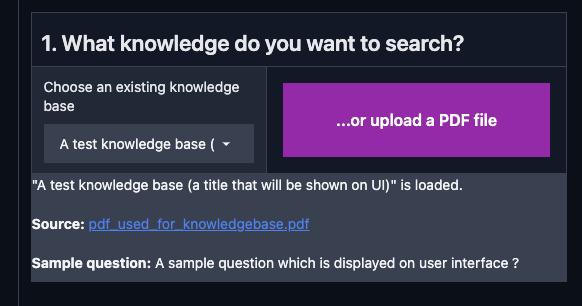

## Tryout a RAG workflow with our KB

### Load the new knowledge base

In [15]:
 
knowledge_base = team_ai_embeddings.generate_from_filesystem('../teams/team_demo/knowledge/pdfs/new_knowledge_base.kb')

### Create LLM model object

Here we try to use model from same cloud provider from which we have used embeddings. It should be noted that LLM and embeddings can come from **different providers/models**. For convinience, we load a LLM based on the **embedding_provider_code** value. 

> Note: Make sure that the **region_name** argument is pointing to right Bedrock region

In [16]:
llm_provider = "open_ai"

In [17]:
from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import BedrockChat

if llm_provider == "open_ai":
    llm = ChatOpenAI(model_name = "gpt-3.5-turbo-16k", temperature=0.7)
elif llm_provider == "aws":
    llm = BedrockChat(model_id="anthropic.claude-v2", region_name="us-east-1",model_kwargs={"temperature": 0.1})
else:
    raise("Invalid llm_provider")

/opt/homebrew/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


### Create the prompt, including retrieved context documents

In [18]:
from langchain.prompts import PromptTemplate
def question_answer_prompt():
    template = """You are a DocuDialog AI provides information over the following pieces of context to answer the question at the end. 
    Do not answer the question if its out of context provided.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.

    context:
    ```
    {context}
    ```
           
    {question}
    Answer in markdown:"""
   
    prompt = PromptTemplate(input_variables=["context", "question"], template=template)
    return prompt

prompt = question_answer_prompt()

### Prompt the model

In [19]:
question = "what is this document about ?"

In [20]:
from langchain.chains import LLMChain
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA

QA_PROMPT = question_answer_prompt()
load_qa = load_qa_chain(llm=llm, chain_type="stuff", prompt=QA_PROMPT, verbose=True)
qa_chain = RetrievalQA(combine_documents_chain=load_qa, retriever=knowledge_base.as_retriever(), return_source_documents=True, verbose=True)  
answer = qa_chain(question)


/opt/homebrew/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
You are a DocuDialog AI provides information over the following pieces of context to answer the question at the end. 
    Do not answer the question if its out of context provided.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.

    context:
    ```
    piece
of
the
wing
cloth
from
the
Wright
brothers
'
1903
Wright
Flyer
is
attached
to
a
cable
underneath
Ingenuity
's
solar
panel.
[8]
In
1969,
Apollo
11
's
Neil
Armstrong
carried
a
similar
Wright
Flyer
artifact
to
the
Moon
in
the
Lunar
Module
Eagle
.

the
tasks
assigned
to
it.
Arguing
with
MiMi
Aung
on
the
air
of
a
joint
conference,
Jennifer
Trosper
warned
that
thanks
to
auto-navigation,
the
rover
ultimately
outpaces
the
helicopter.
These
calculations
were
first
confirmed
in
the
spring
of
2022
when
by
the
beginning
of
Sol
400
the
helicopter
did
not

In [21]:
print(answer['result'])

This document provides information about the Ingenuity helicopter, a small autonomous UAV helicopter deployed on Mars by NASA. It discusses the performance and achievements of Ingenuity, including its flights, altitude, flight duration, and data collection capabilities. The document also mentions the collaboration between NASA's Jet Propulsion Laboratory, AeroVironment, Lockheed Martin Space, Qualcomm, and SolAero in designing and manufacturing Ingenuity. Additionally, it mentions the extension of Ingenuity's mission by NASA and its role in scouting areas of interest for the Perseverance rover.
